<a href="https://colab.research.google.com/github/piniii28/taller_final_ia/blob/main/PARTE_2_land_use_land_cover_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatización de la Cartografía de Uso de Suelo y Cobertura del Suelo usando Python
**Creadores de contenido**: Ankur Mahesh e Isabelle Tingzon

Esta es una continuación del [Parte 1 del Tutorial de Clasificación de Uso de Suelo y Cobertura del Suelo (LULC)](https://github.com/climatechange-ai-tutorials/lulc-classification/blob/main/land_use_land_cover_part1.ipynb). Anteriormente, aprendiste cómo entrenar un modelo de aprendizaje profundo para clasificar parches de imágenes Sentinel-2 en diferentes categorías de uso y cobertura del suelo.

En este tutorial, aprenderás a:
- descargar tus propias imágenes satelitales Sentinel-2A utilizando Google Earth Engine
- utilizar el modelo entrenado en el tutorial anterior para generar automáticamente un mapa LULC para una región de interés

Puedes hacer una copia de este tutorial navegando a Archivo->Guardar una copia en Drive.

## Tabla de Contenidos
1. [Introducción a los Datos Geoespaciales]()
2. [Descargar Límites de Países](#admin-bounds)
3. [Generar Imágenes Satelitales Sentinel-2](#sentinel-2)
4. [Generar Baldosas GeoJSON 64x64 px](#tiles)
5. [Generar Mapa LULC](#lulc-maps)
6. [Conclusión y Próximos Pasos]()


# Introducción a los Datos Geoespaciales

Este tutorial cubre una introducción al procesamiento de datos geoespaciales usando Python. Nuestro objetivo es introducir conceptos básicos y herramientas comúnmente utilizadas para manipular, analizar y visualizar datos geoespaciales. Nuestro público objetivo son aquellos que son nuevos en Python como herramienta para el análisis de datos geoespaciales, así como principiantes en el análisis de datos geoespaciales que buscan herramientas para comenzar.


## Tipos de Datos Espaciales

Las observaciones de datos espaciales se centran en la *ubicación*. Existen dos tipos principales de datos espaciales:
- **Datos vectoriales** - son básicamente puntos, líneas y polígonos. Cada objeto vectorial puede consistir en una o más ubicaciones de coordenadas XY. Los vectores se pueden utilizar para representar, por ejemplo, ubicaciones de lugares (por ejemplo, escuelas, hospitales), carreteras o límites de países. Los objetos vectoriales pueden almacenarse utilizando formatos de datos espaciales como GeoJSON (.geojson), GeoPackage (.gpkg), Shapefile (.shp).
- **Datos raster** - están compuestos por una cuadrícula de píxeles. Los ejemplos incluyen imágenes satelitales multiespectrales, mapas de luminosidad nocturna y mapas de elevación digital. Cada píxel representa un valor o clase, por ejemplo, valores de rojo, verde y azul en imágenes satelitales; intensidad de la luz nocturna en mapas NTL; altura en mapas de elevación. Los datos raster se almacenan comúnmente como GeoTIFFs (.tiff).

Para aprender más sobre vectores y raster, [consulta esta referencia](https://gisgeography.com/spatial-data-types-vector-raster/).

<img src="https://slideplayer.com/slide/6229417/20/images/10/Spatial+data%3A+Vector+vs+Raster.jpg=100x100" width="350"/>


## Sistemas de Referencia de Coordenadas
Las proyecciones cartográficas son representaciones 2D de la Tierra sobre una superficie plana. Pero debido a que la Tierra es esferoidal, no existe una única forma más precisa de representar la Tierra en dos dimensiones, lo que da lugar a varios sistemas de coordenadas que sirven para diferentes propósitos (recomendado ver: ["Por qué todos los mapas del mundo están equivocados" de Vox](https://www.youtube.com/watch?v=kIID5FDi2JQ&ab_channel=Vox)).

**Los sistemas de referencia de coordenadas** (CRS) proporcionan un método para definir ubicaciones del mundo real en el espacio geográfico. Estos sistemas determinan no solo las ubicaciones de las coordenadas de los objetos, sino también cómo se ve tu mapa y cómo se calcula la distancia.

Los datos geoespaciales, ya sean vectoriales o rasterizados, siempre van acompañados de información CRS. Dos sistemas de coordenadas comunes son EPSG:3857 (Web Mercator) y EPSG:4326 (WGS 84); en este tutorial, utilizaremos el segundo CRS.


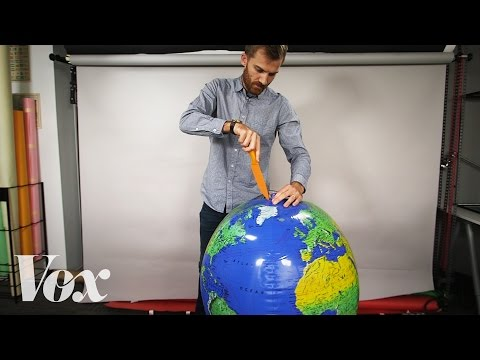

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('kIID5FDi2JQ')

## Herramientas de Procesamiento de Datos Geoespaciales
Presentamos las siguientes herramientas de análisis geoespacial y paquetes de Python:

- [**Google Earth Engine**](https://earthengine.google.com/) - un archivo público de datos de petabytes de imágenes satelitales históricas y conjuntos de datos geoespaciales. En este tutorial, utilizaremos la [API de Python de Earth Engine](https://developers.google.com/earth-engine/#api) para acceder a las imágenes RGB de Sentinel-2. Ten en cuenta que necesitarás registrarte para obtener acceso a Google Earth Engine en https://code.earthengine.google.com/.
- [**GeoPandas**](https://geopandas.org/) - Amplía las funcionalidades de pandas para agregar soporte para datos geográficos y análisis geoespaciales.
- [**Rasterio**](https://rasterio.readthedocs.io/en/latest/) - Los datos rasterizados, como las imágenes satelitales, a menudo se almacenan utilizando el formato GeoTIFF. Rasterio te permite leer y escribir estos formatos y realizar operaciones geoespaciales avanzadas en estos conjuntos de datos.
- [**Folium**](https://python-visualization.github.io/folium/) - Te permite visualizar datos geoespaciales en un mapa interactivo de leaflet.

Para más herramientas de análisis geoespacial, consulta esta [lista completa de paquetes de Python](https://github.com/giswqs/python-geospatial).


# Importaciones y Configuración

In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
# Importaciones estándar
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Paquetes de procesamiento geoespacial
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Bibliotecas para mapeo y gráficos
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Bibliotecas de aprendizaje profundo
import torch
from torchvision import datasets, models, transforms

### Montar el Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Autenticar Google Earth Engine
Asegúrate de haberte registrado para obtener acceso a Google Earth Engine en https://signup.earthengine.google.com/#!/. Una vez que tu solicitud haya sido aprobada, deberías poder acceder a Google Earth Engine en https://code.earthengine.google.com/.


In [ ]:
ee.Authenticate()
ee.Initialize(project="<ENTER PROJECT NAME>")

<a name="admin-bounds"></a>
# Descargar Límites Administrativos del País

Nuestro primer paso es descargar los límites administrativos del país de interés, los cuales obtendremos a través de [geoBoundaries de William and Mary GeoLab](https://www.geoboundaries.org/index.html). geoBoundaries es una base de datos global de límites administrativos políticos de libre acceso, que cubre todos los países del mundo. Los límites geográficos se pueden descargar mediante acceso a la API mediante una consulta sencilla:

```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
- **ISO** - El código ISO de tres letras que representa el país de interés.
  - [Consulta esta página](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) para ver la lista completa de códigos ISO por país.
- **ADM** - Uno de ADM0, ADM1, ADM2, ADM3, ADM4 o ADM5, que representa cada nivel de la jerarquía administrativa.

Para más información, consulta la [documentación de la API](https://www.geoboundaries.org/api.html).

En este ejemplo, elegimos **Alemania** como nuestra área de interés. Establecemos el código ISO a "DEU" y ADM a "ADM2". La consulta debería devolver las geometrías de los 403 distritos administrativos de Alemania. En la siguiente celda, enviamos una solicitud para los límites administrativos de Alemania, guardamos el resultado como un archivo GeoJSON y leemos el archivo usando GeoPandas.

In [ ]:
ISO = 'DEU' # "DEU" es el código ISO para Alemania
ADM = 'ADM3' # Equivalente a distritos administrativos

# Consultar geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Guardar el resultado como un archivo GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Leer los datos usando GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (428, 6)


shapeName shapeISO                  shapeID  \
245  Mönchengladbach, Kreisfreie Stadt            24449704B8697873440410   
378           Erfurt, Kreisfreie Stadt           24449704B63717370629940   
41                       Bodenseekreis           24449704B50316632741849   

    shapeGroup shapeType                                           geometry  
245        DEU      ADM3  POLYGON ((6.52214 51.22573, 6.51734 51.22786, ...  
378        DEU      ADM3  POLYGON ((11.17047 51.01847, 11.16959 51.01741...  
41         DEU      ADM3  POLYGON ((9.07053 47.80730, 9.07075 47.80710, ...

En este ejemplo, visualizamos el límite administrativo del distrito **Kreis Borken** utilizando la función .plot() de GeoPandas.


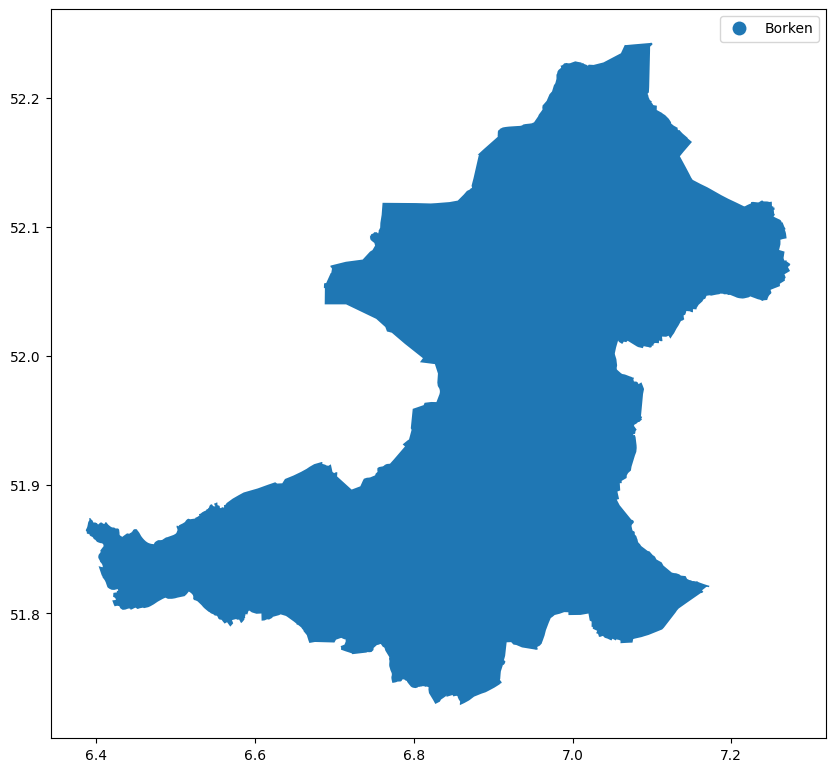

In [ ]:
shape_name = 'Borken'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

<a name="sentinel-2"></a>
# Generar Imágenes Satelitales de Sentinel-2
Sentinel-2 es una misión de observación de la Tierra del Programa Copernicus que proporciona imágenes multiespectrales globales cada 10 días (2015 - presente) con una resolución de 10 m (es decir, la longitud de un lado de un píxel es igual a 10 metros).

Las imágenes suelen estar compuestas por 3 canales o bandas: rojo, verde y azul. Sentinel-2, por otro lado, es capaz de capturar 13 bandas espectrales:
- 4 bandas a 10 metros: azul, verde, rojo y cercano al infrarrojo
- 6 bandas a 20 metros: para caracterización de vegetación y para aplicaciones como detección de nieve/hielo/nubes o evaluación de estrés hídrico de la vegetación.
- 3 bandas a 60 metros: principalmente para cribado de nubes y correcciones atmosféricas.

&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>

Para simplificar, en este tutorial solo utilizamos las bandas Roja, Verde y Azul para la clasificación LULC. Sin embargo, los datos multiespectrales contienen información valiosa que puede ser útil para diversas aplicaciones, como estimación de rendimiento de cultivos, monitoreo de la salud de la vegetación, análisis de expansión de áreas urbanizadas, detección de asentamientos informales y mucho más. Te animamos a explorar todo el potencial de las imágenes satelitales de Sentinel-2 para aplicaciones relacionadas con el clima.

[Aprende más sobre Sentinel-2 aquí](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects).



## Google Earth Engine  
En esta sección, demostraremos cómo usar Google Earth Engine para descargar imágenes satelitales de Sentinel-2. Nuevamente, para simplificar, solo descargaremos las bandas RGB de Sentinel-2: rojo (B4), verde (B3) y azul (B2).

En la siguiente celda, definimos una función para generar una imagen de Sentinel-2 desde Google Earth utilizando la API de Python de Earth Engine. Para minimizar la cobertura de nubes, elegimos agregar una colección de imágenes durante un período de tiempo, en lugar de obtener una sola imagen en una fecha específica.


In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generar un compuesto agregado por mediana
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Obtener las bandas RGB
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Tenga en cuenta que el valor máximo de las bandas RGB se establece en 65535
    # porque las bandas de Sentinel-2 son enteros de 16 bits
    # con un rango numérico completo de [0, 65535] (el valor máximo es 2^16 - 1);
    # sin embargo, los valores reales son mucho menores que el valor máximo.
    # Fuente: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

Generamos y visualizamos la imagen satelital de Sentinel-2 para el distrito de **Kreis Borken**. La imagen satelital se genera obteniendo la mediana de todas las imágenes de Sentinel-2 en 2020 con una cobertura de nubes inferior al 10%.

In [ ]:
# Obtener la geometría de la forma para Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) # Convertir un GeoDataFrame a una FeatureCollection

# Generar imagen RGB usando GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Obtener todas las imágenes dentro
    max_date='2021-12-31', # del año 2021
    cloud_pct=10, # Filtrar imágenes con cobertura de nubes >= 10.0%
)

# Visualizar el mapa
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


## Exportar Imagen a Google Drive Local  
En la siguiente celda, definimos una función para exportar nuestra imagen satelital de Sentinel-2 generada a nuestro Google Drive local.

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

Ahora podemos proceder a descargar la imagen a nuestro Google Drive local como un archivo GeoTIFF.

**Nota**: ¡Ten cuidado al exportar imágenes grandes, ya que pueden tardar un tiempo en descargarse y ocupar mucho espacio de almacenamiento!

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

Exporting to Borken.tif ...


Puedes ejecutar repetidamente `task.status()` para monitorear el estado de la tarea. Después de un tiempo, el estado debería cambiar de "READY" a "RUNNING" y luego a "COMPLETE".

Alternativamente, puedes ir a https://code.earthengine.google.com/ para verificar el estado de la tarea.


In [ ]:
task.status()

{'state': 'RUNNING',
 'description': 'Borken',
 'priority': 100,
 'creation_timestamp_ms': 1717227827019,
 'update_timestamp_ms': 1717227830338,
 'start_timestamp_ms': 1717227830263,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'W3JEHOJXBXEQM7DAXZPDRT5R',
 'name': 'projects/mangrove-mapping/operations/W3JEHOJXBXEQM7DAXZPDRT5R'}

## Visualizar imagen Sentinel-2A

Una vez que el estado de la tarea cambie a “COMPLETA”, verifica que la imagen satelital se encuentre en tu google drive.

En la siguiente celda, cargamos y visualizamos la imagen satelital raster utilizando la librería Rasterio.

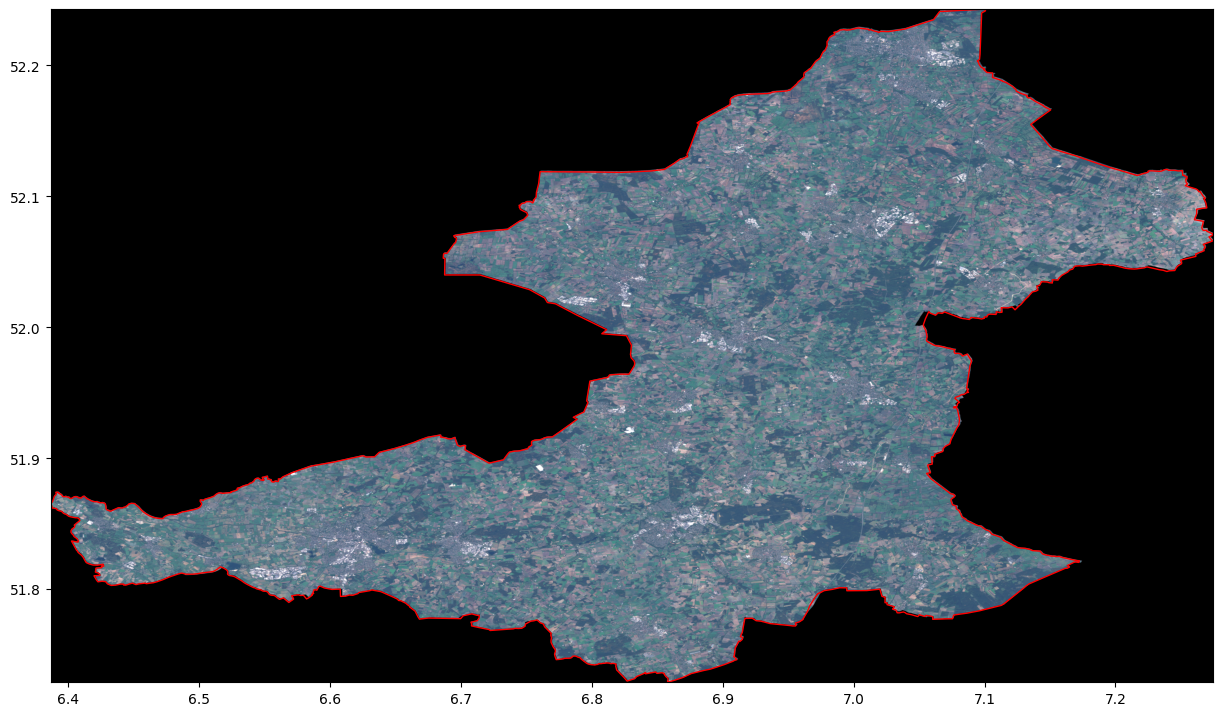

In [ ]:
# Cambia esto a la ruta de tu archivo de imagen
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(shape_name))

# Descomenta esto para descargar el archivo TIF
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Abrir archivo de imagen usando Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Graficar imagen y el límite correspondiente
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generar Mosaicos de 64x64 px en GeoJSON

Recuerda que en el tutorial anterior, entrenamos un modelo de aprendizaje profundo con el [conjunto de datos EuroSAT RGB](), que consiste en fragmentos de imágenes Sentinel-2 de 64x64 píxeles. Esto significa que también necesitaremos dividir nuestra enorme imagen de Sentinel-2 en mosaicos más pequeños de 64x64 px.

Comencemos creando una función que genere una cuadrícula de polígonos cuadrados de 64x64 px usando las [utilidades de la ventana de Rasterio](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).


In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Abrir la imagen raster usando rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Crear un diccionario que contendrá nuestros mosaicos de polígonos de 64 x 64 px
    # Más tarde convertiremos este diccionario en un DataFrame de GeoPandas.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Realizar una ventana deslizante a través de la imagen raster
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Crear una ventana del tamaño deseado
              window = rio.windows.Window(h, w, size, size)
              # Obtener los límites georreferenciados de la ventana
              bbox = rio.windows.bounds(window, raster.transform)
              # Crear una geometría shapely a partir del cuadro delimitador
              bbox = box(*bbox)

              # Crear un identificador único para cada geometría
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Actualizar el diccionario
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Convertir el diccionario en un DataFrame de GeoPandas
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Establecer el CRS a EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Guardar el archivo como GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

Ahora podemos crear polígonos cuadrados de tamaño 64x64 px en la imagen satelital Sentinel-2 de Kreis Borken.

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Descomente esto para descargar el archivo GeoJSON
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/56544804 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (13950, 2)


id                                           geometry
0  borken-0  POLYGON ((6.39259 52.23712, 6.39259 52.24287, ...
1  borken-1  POLYGON ((6.39834 52.23712, 6.39834 52.24287, ...
2  borken-2  POLYGON ((6.40409 52.23712, 6.40409 52.24287, ...

## Visualizar mosaicos de 64 x 64 px

Abramos el archivo raster Sentinel-2 usando Rasterio y superpongamos los polígonos vectoriales de 64x64px de la siguiente manera.

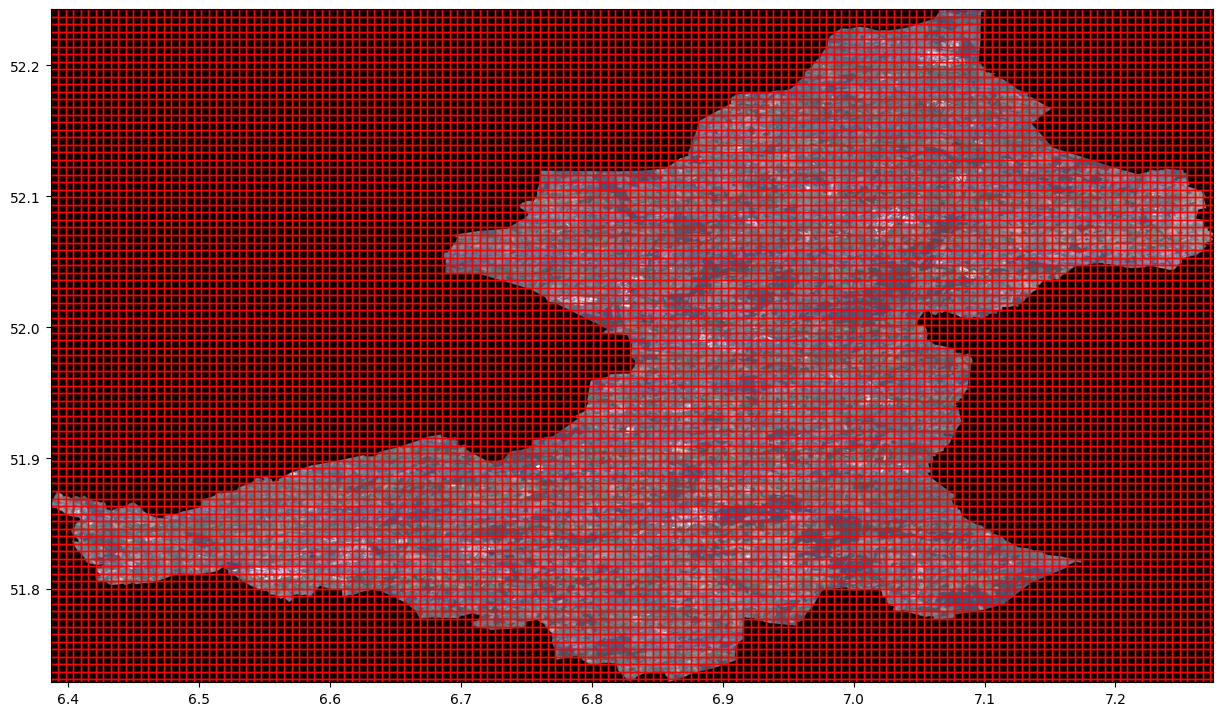

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Tenga en cuenta que los polígonos también se generan para regiones vacías (negras). Usar nuestro modelo para hacer predicciones sobre regiones en blanco parece un desperdicio computacional.

En lugar de ello, podemos obtener la intersección entre:
- el polígono límite del distrito de Borken y
- las cuadrículas de 64 x 64 mosaicos.

Para ello utilizamos GeoPandas `.sjoin()` Función. Establecemos el parámetro `op='within'` para indicar que solo queremos las fichas que se encuentran dentro del límite del distrito.

[Vea más información sobre el funcionamiento conjunto de GeoPandas aquí](https://geopandas.org/reference/geopandas.sjoin.html).


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-42-bf805cd971f2>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


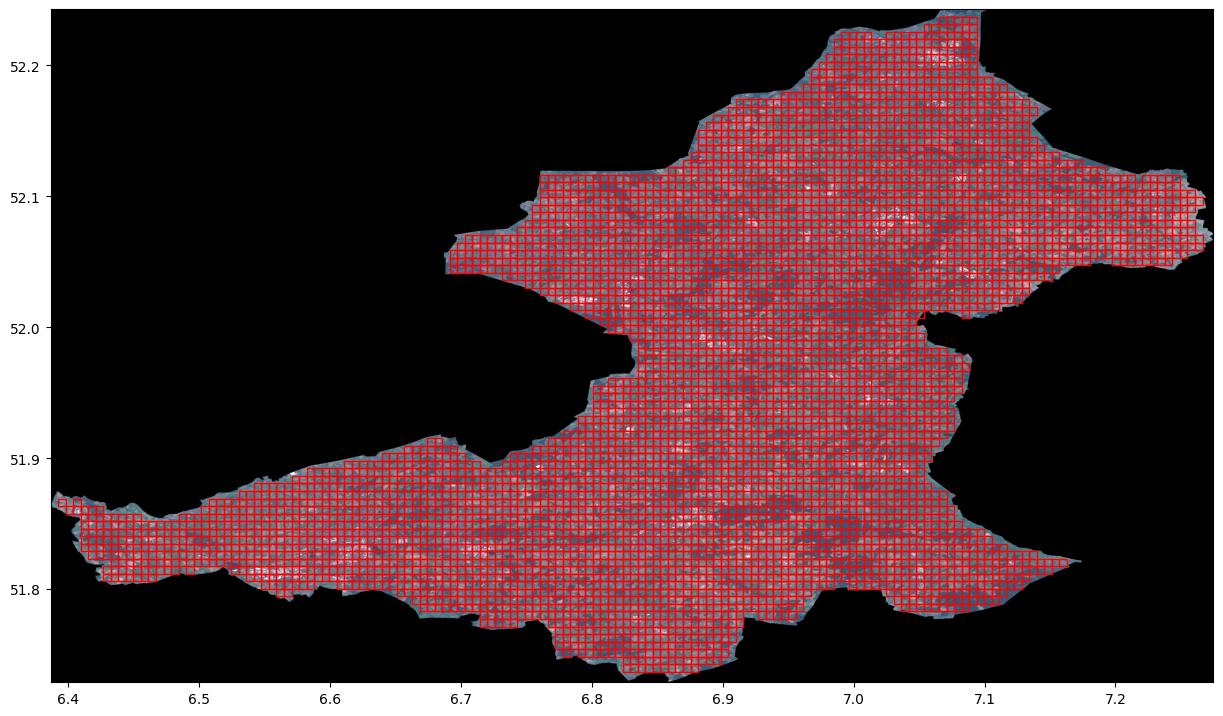

In [ ]:
image = rio.open(tif_file)

# Función sjoin de Geopandas
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualizar una sola imagen recortada
Ahora podemos recortar nuestra imagen de Sentinel-2 usando las cuadrículas generadas.

Aquí, visualizamos la imagen de Sentinel-2 recortada usando el primer mosaico.

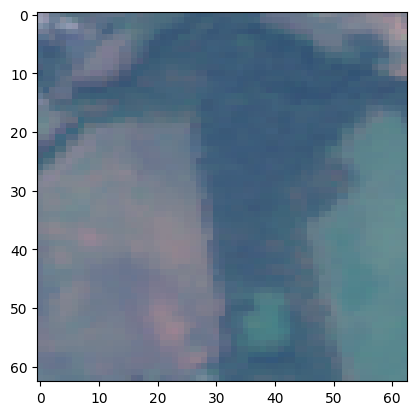

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Recortar el borde negro (cero)
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualizar imagen
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

<a name="lulc-maps"></a>
# Generar mapa de uso y cobertura del suelo
En esta sección, generaremos nuestro mapa de clasificación de uso y cobertura del suelo utilizando el modelo entrenado en el tutorial anterior. Recuerde que el conjunto de datos de EuroSAT consta de 10 clases LULC diferentes, como se indica a continuación.

In [ ]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Modelo de carga entrenado en EuroSAT
Primero, cargue el modelo entrenado.

En caso de que se haya perdido la Parte 1 del tutorial, también puede descomentar el código a continuación para descargar el modelo entrenado directamente.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Descomente esto para descargar el archivo del modelo
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.9MB/s]


Model file ./drive/My Drive/Colab Notebooks//models/best_model.pth successfully loaded.


Recuerde que en el tutorial anterior aplicamos un conjunto de transformaciones de datos a nuestro conjunto de prueba. Antes de ejecutar nuestras nuevas imágenes a través del modelo, necesitaremos aplicar estas mismas transformaciones a nuestros nuevos datos de la siguiente manera.

In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Predicción de modelos y generación de mapas LULC

A continuación, definamos una función que:
1. Recorta la imagen de origen utilizando la geometría de mosaico de 64x64
2. Genera una predicción para la imagen recortada utilizando el modelo entrenado

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Recortar la imagen de origen utilizando la forma del polígono
        # Ver más información aquí:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Recortar el borde negro (cero)
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Obtenga los metadatos de la imagen de origen y actualícelos
        # con el ancho, la altura y la transformación de la imagen recortada
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Guarde la imagen recortada como un archivo TIFF temporal.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

       # Abra la imagen recortada y la predicción generada
        # utilizando el modelo de PyTorch entrenado
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Repasemos cada mosaico de 64 x 64 píxeles y generemos predicciones de modelos para la imagen recortada correspondiente. Tenga en cuenta que estamos sobrescribiendo cada archivo TIFF temporal para ahorrar espacio de almacenamiento.

In [ ]:
# Comenzar la predicción del modelo
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Guardar predicciones
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/5296 [00:00<?, ?it/s]

id                                           geometry  \
273  borken-273  POLYGON ((7.07100 52.23137, 7.07100 52.23712, ...   
274  borken-274  POLYGON ((7.07675 52.23137, 7.07675 52.23712, ...   
275  borken-275  POLYGON ((7.08250 52.23137, 7.08250 52.23712, ...   

     index_right shapeName shapeISO                 shapeID shapeGroup  \
273          270    Borken           24449704B5449167279442        DEU   
274          270    Borken           24449704B5449167279442        DEU   
275          270    Borken           24449704B5449167279442        DEU   

    shapeType     pred  
273      ADM3  Pasture  
274      ADM3  Pasture  
275      ADM3  Pasture

## Visualizar el mapa interactivo LULC
Por último, te mostramos cómo generar un mapa LULC interactivo usando Folium.

Comencemos cargando las predicciones resultantes.

In [ ]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Descomente esto para descargar las predicciones del modelo.
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

id  index_right shapeName shapeISO                 shapeID  \
0  borken-273          270    Borken           24449704B5449167279442   
1  borken-274          270    Borken           24449704B5449167279442   
2  borken-275          270    Borken           24449704B5449167279442   

  shapeGroup shapeType     pred  \
0        DEU      ADM3  Pasture   
1        DEU      ADM3  Pasture   
2        DEU      ADM3  Pasture   

                                            geometry  
0  POLYGON ((7.07100 52.23137, 7.07100 52.23712, ...  
1  POLYGON ((7.07675 52.23137, 7.07675 52.23712, ...  
2  POLYGON ((7.08250 52.23137, 7.08250 52.23712, ...

Luego asignamos cada etiqueta a un color correspondiente.

In [ ]:
# Asignamos cada clase a un color correspondiente
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

id  index_right shapeName shapeISO                 shapeID  \
0  borken-273          270    Borken           24449704B5449167279442   
1  borken-274          270    Borken           24449704B5449167279442   

  shapeGroup shapeType     pred  \
0        DEU      ADM3  Pasture   
1        DEU      ADM3  Pasture   

                                            geometry    color  
0  POLYGON ((7.07100 52.23137, 7.07100 52.23712, ...  #3cb371  
1  POLYGON ((7.07675 52.23137, 7.07675 52.23712, ...  #3cb371

Tenga en cuenta que puede activar o desactivar el mapa utilizando los controles de la parte superior derecha.

In [ ]:
# Crear una instancia del mapa centrado en el centroide
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Añadir mapa base de Google Satellite
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Añadir mapa LULC con leyenda
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Especificar el color de la leyenda
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Agregar GeoJSON al grupo de características
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

# Conclusion
¡Felicitaciones por haber llegado hasta el final! Para resumir, en este tutorial aprendiste a descargar una imagen satelital Sentinel-2 para una región de interés usando Google Earth Engine y a aplicar un modelo CNN entrenado para generar un mapa de uso y cobertura del suelo. Como ejercicio, intenta aplicar el modelo a otra región, por ejemplo, tu país de origen. ¿Qué tan bien funciona el modelo en esta nueva geografía?

## Limitaciones de datos
Si ha intentado aplicar el modelo a otra región del mundo, encontrará que el modelo no funciona tan bien en ciertas áreas. A continuación, se indican algunas de las limitaciones del conjunto de datos EuroSAT:
- **Categorías de escenas limitadas.** Las 10 clases de cobertura terrestre del conjunto de datos EuroSAT no son representativas del contenido complejo de los datos de teledetección. Estas etiquetas de clase no están mutuamente disjuntas (por ejemplo, una imagen puede contener tanto una autopista como una zona residencial) y su unión no cubre la distribución en el mundo real (por ejemplo, ciertos tipos de cobertura terrestre, como las tierras desérticas y la acuicultura, no están presentes en el conjunto de datos).
- **Transferibilidad limitada del modelo.** Al igual que muchos conjuntos de datos de teledetección existentes, EuroSAT, que consta de imágenes satelitales distribuidas por toda Europa, sufre de una cobertura geográfica limitada que restringe la generalización del modelo a otras regiones del mundo. Por lo tanto, es necesaria la colaboración con diversas instituciones de investigación y mayores esfuerzos de intercambio de datos para mejorar la cobertura global de los conjuntos de datos de teledetección anotados.

## Aplicaciones relacionadas con el clima
- **Detección de cambios en el uso y la cobertura del suelo.** Dado que Sentinel-2 continuará recopilando datos RS durante las próximas décadas, un próximo paso prometedor es utilizar el modelo entrenado para observar y detectar cambios en la cobertura del suelo. [MapBiomas](https://plataforma.brasil.mapbiomas.org/), Por ejemplo, es una plataforma que permite visualizar los cambios en el uso de la tierra y el uso del suelo en Brasil durante un largo período de tiempo. Esto puede ser particularmente útil para la planificación urbana, el monitoreo ambiental y la protección de la naturaleza. La deforestación, por ejemplo, contribuye significativamente al cambio climático; el monitoreo de los cambios en la cubierta forestal y la identificación de los factores que impulsan la pérdida de bosques pueden ser útiles para los esfuerzos de conservación y restauración de los bosques.
- **Análisis de las emisiones de carbono derivadas del cambio de uso del suelo.** El análisis de la conversión de la categoría de uso del suelo junto con los cambios en el almacenamiento de carbono del suelo puede ayudar a cuantificar la contribución del cambio de uso del suelo y la gestión del suelo a las emisiones totales de carbono, como se demuestra en este [2016 study by Lai et al](https://advances.sciencemag.org/content/2/11/e1601063). El estudio concluyó que el cambio de uso del suelo, en particular la urbanización, que ha provocado una rápida expansión de las zonas edificadas y una pérdida masiva de almacenamiento de carbono terrestre, ha generado grandes emisiones de carbono en China, lo que puede socavar significativamente los objetivos de reducción de emisiones de carbono a menos que se adopten medidas adecuadas para controlar la urbanización y mejorar la gestión del suelo.
- **Evaluación de la vulnerabilidad de diferentes tipos de cobertura terrestre.** La superposición de mapas de cobertura terrestre con diversos mapas de riesgos geoespaciales (por ejemplo, trayectorias de huracanes, fallas sísmicas y mapas de inundaciones) y mapas de proyecciones climáticas puede ser útil para evaluar la vulnerabilidad de ciertos tipos de cobertura terrestre, como asentamientos y tierras agrícolas, a diferentes riesgos. Cuando se comparten con organizaciones humanitarias y agencias gubernamentales, estos mapas tienen el potencial de respaldar la planificación de la reducción del riesgo de desastres, así como los esfuerzos de mitigación y adaptación climática a largo plazo.

## Otros conjuntos de datos de teledetección
- So2Sat LCZ42: A benchmark dataset for global local climate zones classification  ([data](https://mediatum.ub.tum.de/1483140), [paper](https://arxiv.org/pdf/1912.12171.pdf))
- RESISC45: High resolution remote sensing scene classification dataset( [data](https://www.tensorflow.org/datasets/catalog/resisc45), [paper](https://arxiv.org/abs/1703.00121))
- BigEarthNet: Large-Scale Sentinel-2 Benchmark ([data](http://bigearth.net/), [paper](https://arxiv.org/abs/1902.06148))

[Check out this Github repository](https://github.com/chrieke/awesome-satellite-imagery-datasets) for a more comprehensive collection of satellite imagery datasets.

## Próximos pasos
**¿Le interesa aprender más sobre el cambio climático y el aprendizaje automático?**

Le recomendamos que consulte [our paper](), que ofrece una guía detallada sobre las formas en que se puede utilizar el aprendizaje automático para abordar el cambio climático. No dude en consultar también nuestro [wiki]() y [tutorials]() en nuestro sitio web. También te invitamos a que te unas a las conversaciones en nuestro [discussion forum](), Somete a nuestra [workshops](), asista a nuestro [events]() y [workshops](), Y por supuesto, suscríbete a nuestra [newletter]()!

# Comentario
¿Tiene algún comentario, sugerencia o sugerencia? ¿Le interesa colaborar?

Contact us at:
*   ankur.mahesh@berkeley.edu
*   issatingzon@climatechange.ai
*   milojevicdupontn@gmail.com



# Referencias
- Coordinate Reference Systems – Introduction to Geospatial Concepts. (n.d.). Data Carpentry - Introduction to Geospatial Concepts. Retrieved February 14, 2021, from https://datacarpentry.org/organization-geospatial/03-crs/
- USGS EROS Archive - Sentinel-2. (n.d.). USGS. Retrieved February 14, 2021, from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
- Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang, and Deren Li. “DIRS: On creating benchmark datasets for remote sensing image interpretation.” arXiv preprint arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
- Zhu, Xiao Xiang, et al. “So2Sat LCZ42: A benchmark dataset for global local climate zones classification.” arXiv preprint arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
- Sumbul, Gencer, et al. "Bigearthnet: A large-scale benchmark archive for remote sensing image understanding." IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
- Lai, Li, et al. "Carbon emissions from land-use change and management in China between 1990 and 2010." Science Advances 2.11 (2016): e1601063.